## Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner_py3 as miner
%matplotlib inline
plt.style.use('ggplot')

## Create directory to save output files

In [113]:
# Path to the miner directory
input_path = os.path.join(os.path.expanduser('~'),'Desktop','GitHub','miner','miner')

# create name for results folder where output files will be saved
resultsFolder = "results_miner3_stabilized"

# name of the folder containing the miner network
networkFolder = "miner_network_results"
#networkFolder = "results_minCorrelation_0o2_50_allFiles"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load primary data

In [114]:
# Load expression Data
expressionFile = os.path.join(input_path,"data","expression","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0)
expressionData, conversionTable = miner.preprocess(expressionFile)

# Load mutations
common_mutations = pd.read_csv(os.path.join(input_path,'data','mutations','commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(input_path,'data','mutations','translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(input_path,'data','mutations','cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(input_path,networkFolder,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(input_path,networkFolder,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(input_path,networkFolder,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(input_path,networkFolder,"eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

## Load network

In [115]:
# Load Causal Mechanistic Network
filtered_causal_results = pd.read_csv(os.path.join(input_path,networkFolder,"filteredCausalResults.csv"),index_col=0,header=0)

In [116]:
# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

In [117]:
# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

## Load primary survival data

In [118]:
# load primary survival data (i.e., corresponding to expression data training set)
survivalMMRF = pd.read_csv(os.path.join(input_path,"data","survival","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)

## Define patient populations

In [119]:
baseline_patients = [name for name in expressionData.columns if name.split("_")[2]=='1']
relapse_patients = [name for name in expressionData.columns if name.split("_")[2]=='2']
all_relapse_patients = [name for name in expressionData.columns if name.split("_")[2]!='1']
print('Baseline:',len(baseline_patients),'First relapse:',len(relapse_patients),'\nAny relapse:',len(all_relapse_patients))

Baseline: 779 First relapse: 56 
Any relapse: 102


In [120]:
import importlib
importlib.reload(miner)
subtypes_translocations = [
    "RNASeq_CCND1_Call",
    "RNASeq_WHSC1_Call",
    "RNASeq_MAF_Call",
    "RNASeq_MYC_Call"
]

subtypes_cytogenetics = [
    "del17",
    "amp1q"
]

patients_by_subtype = []
for subtype in subtypes_cytogenetics:
    subtype_patients = miner.getMutations(subtype,cytogenetics)
    subtype_patients = [name for name in guanSurvivalDfMMRF.index if name in subtype_patients]
    subtype_patients.reverse()
    patients_by_subtype.append(subtype_patients)

for subtype in subtypes_translocations:
    subtype_patients = miner.getMutations(subtype,translocations)
    subtype_patients = [name for name in guanSurvivalDfMMRF.index if name in subtype_patients]
    subtype_patients.reverse()
    patients_by_subtype.append(subtype_patients)
    
remainder = [name for name in guanSurvivalDfMMRF.index if name not in np.hstack(patients_by_subtype)]
remainder.reverse()

sorted_by_subtype = np.hstack([remainder,np.hstack(patients_by_subtype),relapse_patients])

## Infer nework-constrained gene activity

In [121]:
network_activity_overexpressed = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=overExpressedMembersMatrix.copy(),
                                                 minRegulons = 2)
network_activity_underexpressed = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=underExpressedMembersMatrix.copy(),
                                                 minRegulons = 2)
network_activity_diff = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=diff_matrix_MMRF.copy(),
                                                 minRegulons = 2)

completed transformation in 0.49 minutes
completed transformation in 0.53 minutes
completed transformation in 0.47 minutes


## Load genes of interest

In [122]:
arid1a = "ENSG00000117713"
myc = "ENSG00000136997"
nfkb1 = "ENSG00000109320"
cflar = "ENSG00000003402"
tnfsf9 = "ENSG00000125657"
birc2 = "ENSG00000110330"
birc3 = "ENSG00000023445"
kif11 = "ENSG00000138160"

ilkap = "ENSG00000132323"
bmp2k = "ENSG00000138756"
dedd2 = "ENSG00000160570"
bbc3 = "ENSG00000105327"
apobec3g = "ENSG00000239713"
braf = "ENSG00000157764"
adam17 = "ENSG00000151694"
ddb1 = "ENSG00000167986"
btla = "ENSG00000186265"
bcl2 = "ENSG00000171791"
bax = "ENSG00000087088"
bbc3 = "ENSG00000105327"
mcl1 = "ENSG00000143384"
bcl2a1 = "ENSG00000140379"
nr3c1 = "ENSG00000113580"
aurka = "ENSG00000087586"
aurkb = "ENSG00000178999"
il6r = "ENSG00000160712"
aph1a = "ENSG00000117362"
ago1 = "ENSG00000092847"

ccnd1 = "ENSG00000110092"
ccnd2 = "ENSG00000118971"
ccndbp = "ENSG00000166946"
parp1 = "ENSG00000143799"
parpbp = "ENSG00000185480"
cdk4 = "ENSG00000135446"
brca1 = "ENSG00000012048"
rad51 = "ENSG00000051180"
phf19 = "ENSG00000119403"
her2 = "ENSG00000141736"
egfr = "ENSG00000146648"
fgfr3 = "ENSG00000068078"
mdm2 = "ENSG00000135679"
xpo1 = "ENSG00000082898"
hras = "ENSG00000174775"
nras = "ENSG00000213281"
kras = "ENSG00000133703"

lsm1 = "ENSG00000175324"
tcf3 = "ENSG00000071564"
psmb5 = "ENSG00000100804"
psma3 = "ENSG00000100567"
maf = "ENSG00000178573"
nsd2 = "ENSG00000109685"
tp53 = "ENSG00000141510"
mdm2 = "ENSG00000135679"
e2f1 = "ENSG00000101412"
rb1 = "ENSG00000139687"
foxm1 = "ENSG00000111206"

hdac1 = "ENSG00000116478"
hdac2 = "ENSG00000196591"
hdac6 = "ENSG00000094631"
hdac7 = "ENSG00000061273"
hdac9 = "ENSG00000048052"

crbn = "ENSG00000113851"
ikzf1 = "ENSG00000185811"
ikzf3 = "ENSG00000161405"


PSMA2 = "ENSG00000106588"
PSMA3 = "ENSG00000100567"
PSMB5 = "ENSG00000100804"
PSMB7 = "ENSG00000136930"
PSMC1 = "ENSG00000100764"
PSMC5 = "ENSG00000087191"
PSMC6 = "ENSG00000100519"
PSMC3IP = "ENSG00000131470"
PSMD1 = "ENSG00000173692"
PSMD3 = "ENSG00000108344"
PSMD4 = "ENSG00000159352"
PSMD5 = "ENSG00000095261"
PSMD7 = "ENSG00000103035"
PSMD8 = "ENSG00000099341"
PSMD12 = "ENSG00000197170"
PSME4 = "ENSG00000068878"
PSMG4 = "ENSG00000180822"

ctla = "ENSG00000163599"
cd47 = "ENSG00000196776"
il1b = "ENSG00000125538"
abcc5 = "ENSG00000114770"
il18 = "ENSG00000150782"
micb = "ENSG00000204516"
adamst10 = "ENSG00000142303"

romo1 = "ENSG00000125995"
cks1b = "ENSG00000173207"
actn4 = "ENSG00000130402"
ranbp1 = "ENSG00000099901"

fgfr3 = "ENSG00000068078"
gsk3b = "ENSG00000082701"
creb1 = "ENSG00000118260"
bad = "ENSG00000002330"
dapk1 = "ENSG00000196730"
usp7 = "ENSG00000187555"
usp14 = "ENSG00000101557"
brd4 = "ENSG00000141867"
iap1 = "ENSG00000110330"
iap2 = "ENSG00000023445"
xiap = "ENSG00000101966"

mek = "ENSG00000169032"
akt1 = "ENSG00000142208"
pik3ca = "ENSG00000121879"
mtor = "ENSG00000198793"
cdk6 = "ENSG00000105810"
btk = "ENSG00000010671"
bcl6 = "ENSG00000113916"
rps6ka1 = "ENSG00000281877"
notch1 = "ENSG00000148400"

nlrp3 = "ENSG00000162711"
nek7 = "ENSG00000151414"
casp9 = "ENSG00000132906"
nlrp1 = "ENSG00000091592"
nlrp2 = "ENSG00000022556"
mical1 = "ENSG00000135596"
fgr = "ENSG00000000938"
il1r1 = "ENSG00000115594"
il1r2 = "ENSG00000115590"
s100a8 = "ENSG00000143546"
s100a9 = "ENSG00000163220"
il18rap = "ENSG00000115607"
hdac4 = "ENSG00000068024"
csf1 = "ENSG00000184371"
csf3r = "ENSG00000119535"
irak3 = "ENSG00000090376"
mmp9 = "ENSG00000100985"
fap = "ENSG00000078098"
tsen15 = "ENSG00000198860"
dis3 = "ENSG00000083520"
anp32e = "ENSG00000143401"
usp1 = "ENSG00000162607"
bub1 = "ENSG00000169679"

lair1 = "ENSG00000278154"
lcp1 = "ENSG00000136167"
cflip = "ENSG00000003402" #cflar
bid = "ENSG00000015475"
bax = "ENSG00000087088"
bclxl = "ENSG00000171552" #bcl2l1
diablo = "ENSG00000184047" #smac
casp3 = "ENSG00000164305"
casp8 = "ENSG00000064012"
fadd = "ENSG00000168040"
tradd = "ENSG00000102871"
tnfr1 = "ENSG00000067182"
tnfr2 = "ENSG00000028137"
tnf = "ENSG00000232810"

nasp = "ENSG00000132780"
dnajc9 = "ENSG00000213551"
atf6 = "ENSG00000118217"
anpep = "ENSG00000166825"

puma = "ENSG00000105327"
bim = "ENSG00000153094"
noxa = "ENSG00000141682"
bak = "ENSG00000030110"
bcl2a1 = "ENSG00000140379"
bcl2 = "ENSG00000171791"
mcl1 = "ENSG00000143384"


baseline_targets = [
    crbn,
    ikzf1,
    ikzf3,
    nr3c1,
    psmb5
]

pipeline_targets = [
    hdac6,
    aph1a,
    parp1,
    kif11,
    gsk3b,
    aurka,
    aurkb,
    hdac2,
    anpep,
]

novel_targets = [
    ranbp1,
    parpbp,
    ago1,
    atf6,
    tsen15,
    nek7,
    birc3,
    lair1,
    lcp1,
    dnajc9,
    nasp,
    romo1,
    lsm1,
    bcl6
]

anti_apoptotic_genes = [
    bcl2,
    mcl1,
    bcl2a1
]

pro_apoptotic_genes = [
    puma,
    bim,
    noxa,
    bak
]

apoptosis_genes = np.concatenate([pro_apoptotic_genes,anti_apoptotic_genes])


## Baseline targets

In [123]:
features = baseline_targets
data_df = network_activity_overexpressed.copy()
sort_df = guanSurvivalDfMMRF.copy()
sort_column = "GuanScore"
breaks = 10

subtype = "del17"
samples = miner.getMutations(subtype,cytogenetics) 
del17_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "amp1q"
samples = miner.getMutations(subtype,cytogenetics) 
amp1q_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_CCND1_Call"
samples = miner.getMutations(subtype,translocations) 
ccnd1_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_WHSC1_Call"
samples = miner.getMutations(subtype,translocations) 
nsd2_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_MAF_Call"
samples = miner.getMutations(subtype,translocations) 
maf_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_MYC_Call"
samples = miner.getMutations(subtype,translocations) 
myc_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

samples = remainder 
remainder_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

samples = relapse_patients 
relapse_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks,override=True)

heatmap_list = [remainder_subsets,
                del17_subsets,
                amp1q_subsets,
                ccnd1_subsets,
                nsd2_subsets,
                maf_subsets,
                myc_subsets,
                relapse_subsets
               ]


stitched_map = miner.stitchHeatmaps(heatmap_list,plot=False)


querying 1-5...done.
Finished.


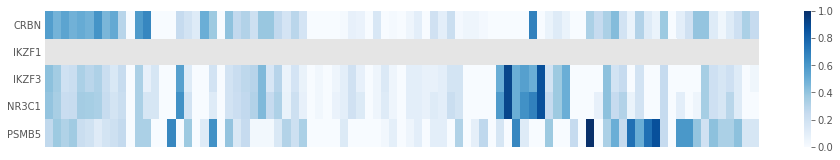

In [124]:
plt.figure(figsize=(16,2.5))
automatic_labels = miner.gene_conversion(stitched_map.index,list_symbols=True)
ax = sns.heatmap(stitched_map,cmap = "Blues",square=False,
            yticklabels=automatic_labels, xticklabels="",vmin=0,vmax=1)
ax.tick_params(axis='both', which='both', length=0)

#plt.savefig(os.path.join(resultsDirectory,"Baseline_targets_heatmap.pdf"),bbox_inches="tight")

## Pipeline targets

In [125]:
features = pipeline_targets
data_df = network_activity_overexpressed.copy()
sort_df = guanSurvivalDfMMRF.copy()
sort_column = "GuanScore"
breaks = 10

subtype = "del17"
samples = miner.getMutations(subtype,cytogenetics) 
del17_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "amp1q"
samples = miner.getMutations(subtype,cytogenetics) 
amp1q_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_CCND1_Call"
samples = miner.getMutations(subtype,translocations) 
ccnd1_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_WHSC1_Call"
samples = miner.getMutations(subtype,translocations) 
nsd2_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_MAF_Call"
samples = miner.getMutations(subtype,translocations) 
maf_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_MYC_Call"
samples = miner.getMutations(subtype,translocations) 
myc_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

samples = remainder 
remainder_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

samples = relapse_patients 
relapse_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks,override=True)

heatmap_list = [remainder_subsets,
                del17_subsets,
                amp1q_subsets,
                ccnd1_subsets,
                nsd2_subsets,
                maf_subsets,
                myc_subsets,
                relapse_subsets
               ]


stitched_map = miner.stitchHeatmaps(heatmap_list,plot=False)


querying 1-9...done.
Finished.


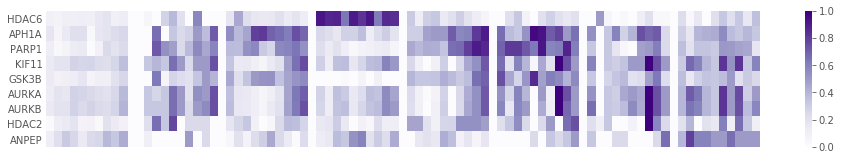

In [126]:
plt.figure(figsize=(16,2.5))
automatic_labels = miner.gene_conversion(stitched_map.index,list_symbols=True)
ax = sns.heatmap(stitched_map,cmap = "Purples",square=False,
            yticklabels=automatic_labels, xticklabels="",vmin=0,vmax=1)
ax.tick_params(axis='both', which='both', length=0)

#plt.savefig(os.path.join(resultsDirectory,"Pipeline_targets_heatmap.pdf"),bbox_inches="tight")

## Novel targets

In [134]:
features = novel_targets
data_df = network_activity_overexpressed.copy()
sort_df = guanSurvivalDfMMRF.copy()
sort_column = "GuanScore"
breaks = 10

subtype = "del17"
samples = miner.getMutations(subtype,cytogenetics) 
del17_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "amp1q"
samples = miner.getMutations(subtype,cytogenetics) 
amp1q_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_CCND1_Call"
samples = miner.getMutations(subtype,translocations) 
ccnd1_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_WHSC1_Call"
samples = miner.getMutations(subtype,translocations) 
nsd2_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_MAF_Call"
samples = miner.getMutations(subtype,translocations) 
maf_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_MYC_Call"
samples = miner.getMutations(subtype,translocations) 
myc_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

samples = remainder 
remainder_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

samples = relapse_patients 
relapse_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks,override=True)

heatmap_list = [remainder_subsets,
                del17_subsets,
                amp1q_subsets,
                ccnd1_subsets,
                nsd2_subsets,
                maf_subsets,
                myc_subsets,
                relapse_subsets
               ]


stitched_map = miner.stitchHeatmaps(heatmap_list,plot=False)


querying 1-14...done.
Finished.


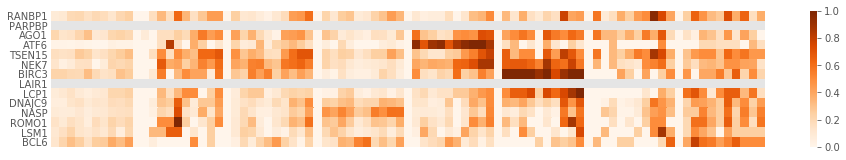

In [135]:
plt.figure(figsize=(16,2.5))
automatic_labels = miner.gene_conversion(stitched_map.index,list_symbols=True)
ax = sns.heatmap(stitched_map,cmap = "Oranges",square=False,
                 yticklabels=automatic_labels, xticklabels="",vmin=0,vmax=1)
ax.tick_params(axis='both', which='both', length=0)

#plt.savefig(os.path.join(resultsDirectory,"Novel_targets_heatmap.pdf"),bbox_inches="tight")

## Apoptosis targets (BCL2 inhibitors)

In [129]:
features = apoptosis_genes
data_df = network_activity_overexpressed.copy()
sort_df = guanSurvivalDfMMRF.copy()
sort_column = "GuanScore"
breaks = 10

subtype = "del17"
del17_mut = miner.getMutations(subtype,cytogenetics) 
del17_subsets = miner.sortedHeatmap(features,del17_mut,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "amp1q"
amp1q_mut = miner.getMutations(subtype,cytogenetics) 
amp1q_subsets = miner.sortedHeatmap(features,amp1q_mut,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_CCND1_Call"
t1114_mut = miner.getMutations(subtype,translocations) 
ccnd1_subsets = miner.sortedHeatmap(features,t1114_mut,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_WHSC1_Call"
t414_mut = miner.getMutations(subtype,translocations) 
nsd2_subsets = miner.sortedHeatmap(features,t414_mut,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_MAF_Call"
t1416_mut = miner.getMutations(subtype,translocations) 
maf_subsets = miner.sortedHeatmap(features,t1416_mut,data_df,sort_df,sort_column,num_breaks=breaks)

subtype = "RNASeq_MYC_Call"
myc_mut = miner.getMutations(subtype,translocations) 
myc_subsets = miner.sortedHeatmap(features,myc_mut,data_df,sort_df,sort_column,num_breaks=breaks)

samples = remainder 
remainder_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks)

samples = relapse_patients 
relapse_subsets = miner.sortedHeatmap(features,samples,data_df,sort_df,sort_column,num_breaks=breaks,override=True)

heatmap_list = [remainder_subsets,
                del17_subsets,
                amp1q_subsets,
                ccnd1_subsets,
                nsd2_subsets,
                maf_subsets,
                myc_subsets,
                relapse_subsets
               ]


stitched_map = miner.stitchHeatmaps(heatmap_list,plot=False)


querying 1-7...done.
Finished.


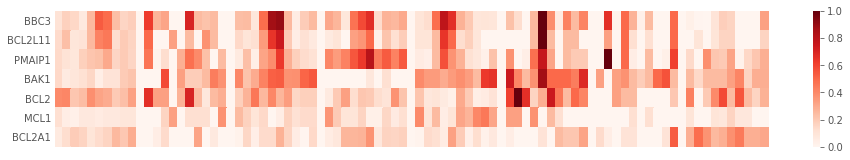

In [130]:
plt.figure(figsize=(16,2.5))
automatic_labels = miner.gene_conversion(stitched_map.index,list_symbols=True)
ax = sns.heatmap(stitched_map,cmap = "Reds",square=False,
                 yticklabels=automatic_labels, xticklabels="",vmin=0,vmax=1)
ax.tick_params(axis='both', which='both', length=0)

#plt.savefig(os.path.join(resultsDirectory,"Apoptosis_genes_heatmap.pdf"),bbox_inches="tight")

## Analyze apoptosis genes for t(11;14) signature

In [136]:
network_activity = network_activity_diff.copy()
noxa_over_bak = {'CCND1':np.array(network_activity.loc[ccnd1,:]),
                 'NOXA':np.array(network_activity.loc[noxa,:]),
                 'BAK':np.array(network_activity.loc[bak,:]),
                 'NOXA/BAK':np.array(network_activity.loc[noxa,:])-np.array(network_activity.loc[bak,:]),                 
                }
noxa_over_bak = pd.DataFrame(noxa_over_bak)
noxa_over_bak.index = network_activity.columns
noxa_over_bak.head()

,CCND1,NOXA,BAK,NOXA/BAK
MMRF_1270_1_BM,0.285714,0.0,0.0,0.0
MMRF_1037_1_BM,0.000000,0.0,0.0,0.0
MMRF_2644_1_BM,0.142857,1.0,0.0,1.0
MMRF_1235_1_BM,-0.714286,-1.0,1.0,-2.0
MMRF_1621_1_BM,0.071429,0.0,0.0,0.0


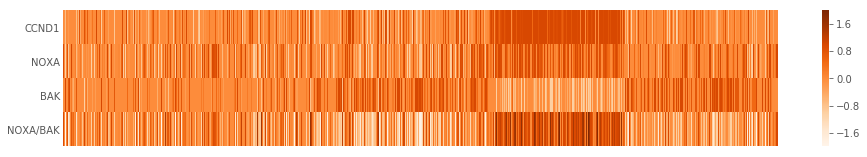

In [137]:
subtype_pats = np.hstack([remainder,
                         del17_mut,
                         amp1q_mut,
                         t1114_mut,
                         t414_mut,
                         t1416_mut,
                         myc_mut])

plt.figure(figsize=(16,2.5))
venetoclax_markers = noxa_over_bak.loc[subtype_pats,:]
venetoclax_markers = venetoclax_markers.T
hmap = sns.heatmap(venetoclax_markers,cmap = "Oranges",square=False)
hmap.set_yticklabels(labels = venetoclax_markers.index,rotation=0)
hmap.set_xticklabels(labels="",FontSize=0)
hmap.tick_params(axis='both', which='both', length=0)

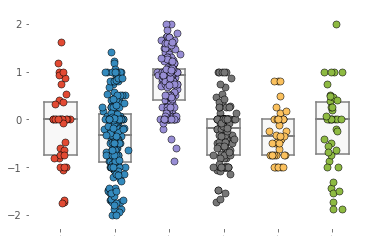

In [138]:
#Boxplots of NOXA:BAK ratio by subtype
miner.boxplot([noxa_over_bak.loc[del17_mut,'NOXA/BAK'],
              noxa_over_bak.loc[amp1q_mut,'NOXA/BAK'],
              noxa_over_bak.loc[t1114_mut,'NOXA/BAK'],
              noxa_over_bak.loc[t414_mut,'NOXA/BAK'],
              noxa_over_bak.loc[t1416_mut,'NOXA/BAK'],
              noxa_over_bak.loc[myc_mut,'NOXA/BAK'],
              ])